In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("Размерность данных:", X.shape)
print("Признаки:", housing.feature_names)
print("Описательная статистика целевой переменной:")
print(pd.Series(y).describe())


Размерность данных: (20640, 8)
Признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Описательная статистика целевой переменной:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
dtype: float64


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)


Размер обучающей выборки: (16512, 8)
Размер тестовой выборки: (4128, 8)


In [3]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
ridge_model = Ridge(alpha=1.0, random_state=42)

gb_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)

gb_pred = gb_model.predict(X_test_scaled)
ridge_pred = ridge_model.predict(X_test_scaled)

print("Базовые модели - метрики на тестовой выборке:")
print("Gradient Boosting - RMSE:", np.sqrt(mean_squared_error(y_test, gb_pred)))
print("Gradient Boosting - R²:", r2_score(y_test, gb_pred))
print("Ridge Regression - RMSE:", np.sqrt(mean_squared_error(y_test, ridge_pred)))
print("Ridge Regression - R²:", r2_score(y_test, ridge_pred))


Базовые модели - метрики на тестовой выборке:
Gradient Boosting - RMSE: 0.5422167577867202
Gradient Boosting - R²: 0.7756433164710084
Ridge Regression - RMSE: 0.7455567442814779
Ridge Regression - R²: 0.5758157428913684


In [5]:
from tqdm import tqdm

def monte_carlo_predictions(model, X_train, y_train, X_test, n_iterations=100, sample_size=0.8):
    predictions = np.zeros((X_test.shape[0], n_iterations))

    for i in tqdm(range(n_iterations)):
        indices = np.random.choice(
            np.arange(X_train.shape[0]),
            size=int(X_train.shape[0] * sample_size),
            replace=True
        )

        X_sample = X_train[indices]
        y_sample = y_train[indices]

        model_copy = clone(model)
        model_copy.fit(X_sample, y_sample)

        predictions[:, i] = model_copy.predict(X_test)

    return np.mean(predictions, axis=1)

from sklearn.base import clone

n_iterations = 50
sample_size = 0.8

gb_mc_pred = monte_carlo_predictions(
    gb_model, X_train_scaled, y_train, X_test_scaled,
    n_iterations=n_iterations, sample_size=sample_size
)

ridge_mc_pred = monte_carlo_predictions(
    ridge_model, X_train_scaled, y_train, X_test_scaled,
    n_iterations=n_iterations, sample_size=sample_size
)

print("\nМодели с применением метода Монте-Карло - метрики на тестовой выборке:")
print("Gradient Boosting MC - RMSE:", np.sqrt(mean_squared_error(y_test, gb_mc_pred)))
print("Gradient Boosting MC - R²:", r2_score(y_test, gb_mc_pred))
print("Ridge Regression MC - RMSE:", np.sqrt(mean_squared_error(y_test, ridge_mc_pred)))
print("Ridge Regression MC - R²:", r2_score(y_test, ridge_mc_pred))


100%|██████████| 50/50 [00:00<00:00, 158.10it/s]


Модели с применением метода Монте-Карло - метрики на тестовой выборке:
Gradient Boosting MC - RMSE: 0.5378896249268003
Gradient Boosting MC - R²: 0.779209961616498
Ridge Regression MC - RMSE: 0.7421709513213348
Ridge Regression MC - R²: 0.5796596863029464



Сравнение метрик всех моделей:
                          RMSE       MAE        R²
Gradient Boosting     0.542217   0.37165  0.775643
Ridge Regression      0.745557  0.533193  0.575816
Gradient Boosting MC   0.53789  0.367309   0.77921
Ridge Regression MC   0.742171   0.53036   0.57966


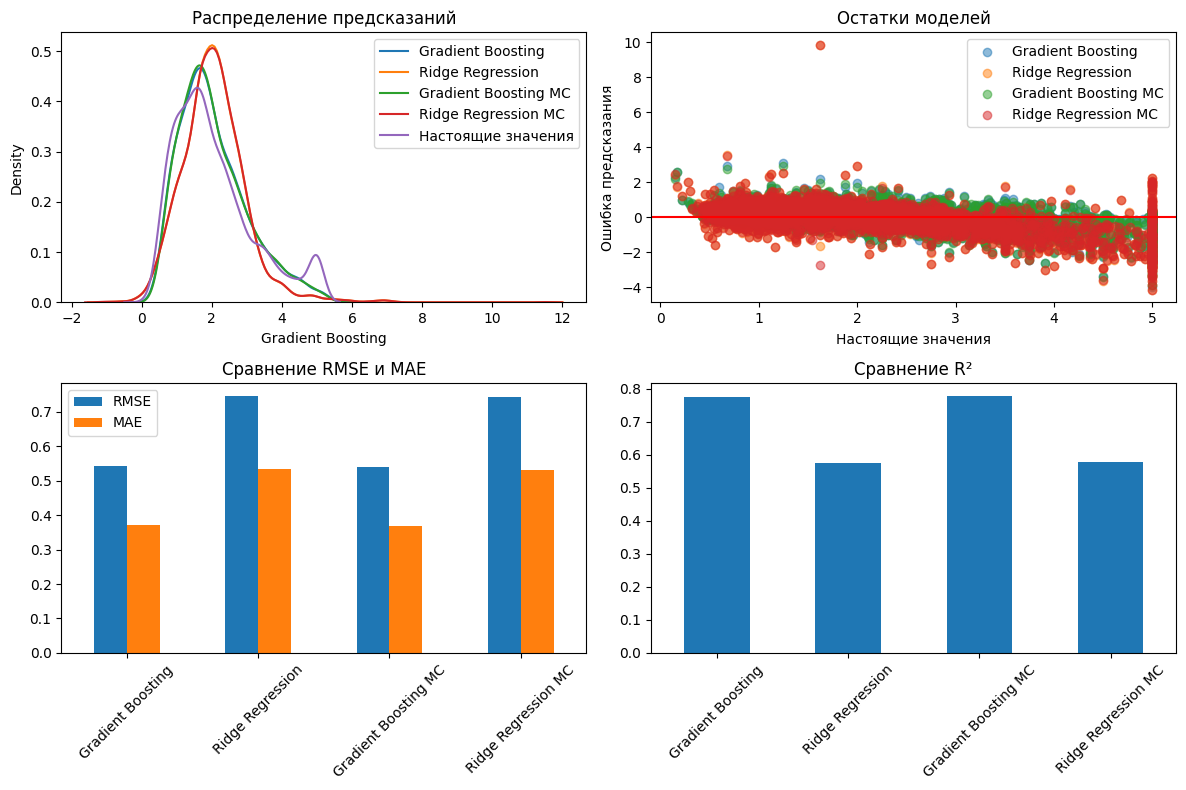

100%|██████████| 50/50 [00:00<00:00, 230.77it/s]


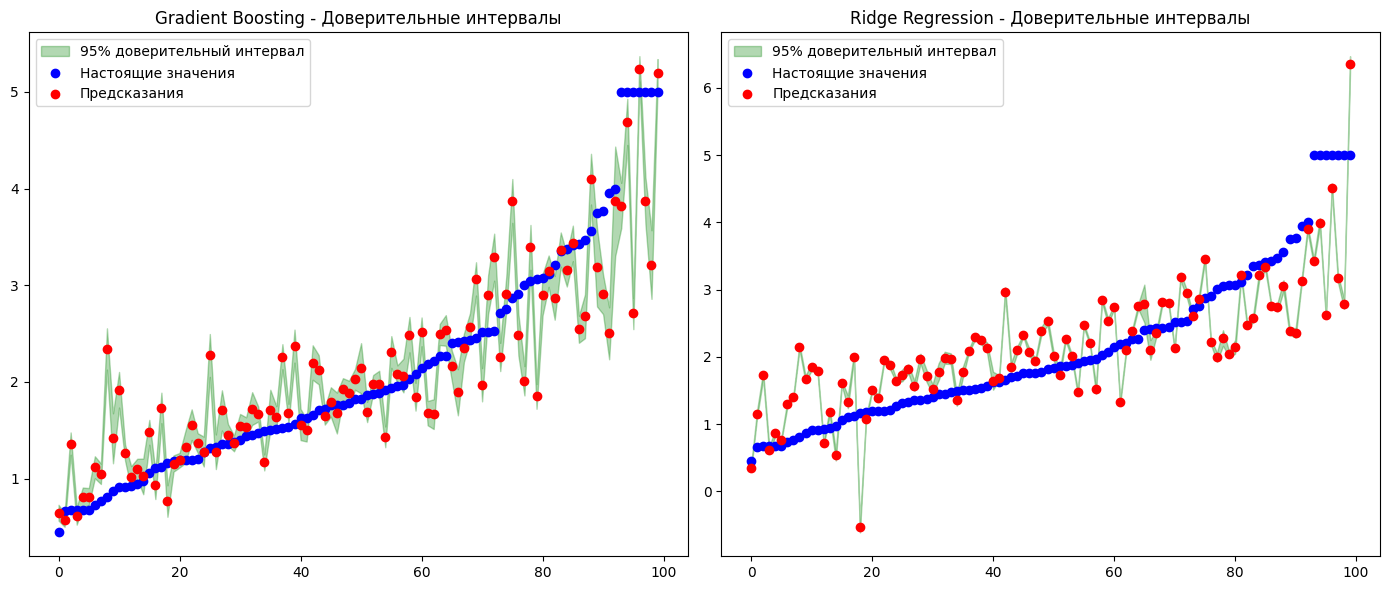


Средняя ширина 95% доверительных интервалов:
Gradient Boosting: 0.3307
Ridge Regression: 0.1380


In [7]:
results = pd.DataFrame({
    'Настоящие значения': y_test,
    'Gradient Boosting': gb_pred,
    'Ridge Regression': ridge_pred,
    'Gradient Boosting MC': gb_mc_pred,
    'Ridge Regression MC': ridge_mc_pred
})

models = ['Gradient Boosting', 'Ridge Regression', 'Gradient Boosting MC', 'Ridge Regression MC']
metrics = pd.DataFrame(index=models, columns=['RMSE', 'MAE', 'R²'])

for model in models:
    metrics.loc[model, 'RMSE'] = np.sqrt(mean_squared_error(y_test, results[model]))
    metrics.loc[model, 'MAE'] = mean_absolute_error(y_test, results[model])
    metrics.loc[model, 'R²'] = r2_score(y_test, results[model])

print("\nСравнение метрик всех моделей:")
print(metrics)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for model in models:
    sns.kdeplot(results[model], label=model)
sns.kdeplot(results['Настоящие значения'], label='Настоящие значения')
plt.title('Распределение предсказаний')
plt.legend()

plt.subplot(2, 2, 2)
for model in models:
    plt.scatter(results['Настоящие значения'], results[model] - results['Настоящие значения'],
                alpha=0.5, label=model)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Остатки моделей')
plt.xlabel('Настоящие значения')
plt.ylabel('Ошибка предсказания')
plt.legend()

plt.subplot(2, 2, 3)
metrics[['RMSE', 'MAE']].plot(kind='bar', ax=plt.gca())
plt.title('Сравнение RMSE и MAE')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
metrics['R²'].plot(kind='bar', ax=plt.gca())
plt.title('Сравнение R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

def compute_confidence_intervals(model, X_train, y_train, X_test, n_iterations=100, sample_size=0.8):
    predictions = np.zeros((X_test.shape[0], n_iterations))

    for i in tqdm(range(n_iterations)):
        indices = np.random.choice(
            np.arange(X_train.shape[0]),
            size=int(X_train.shape[0] * sample_size),
            replace=True
        )

        X_sample = X_train[indices]
        y_sample = y_train[indices]

        model_copy = clone(model)
        model_copy.fit(X_sample, y_sample)

        predictions[:, i] = model_copy.predict(X_test)

    mean_preds = np.mean(predictions, axis=1)
    std_preds = np.std(predictions, axis=1)

    lower_bound = mean_preds - 1.96 * std_preds
    upper_bound = mean_preds + 1.96 * std_preds

    return mean_preds, lower_bound, upper_bound

gb_mean, gb_lower, gb_upper = compute_confidence_intervals(
    gb_model, X_train_scaled, y_train, X_test_scaled, n_iterations=50
)
ridge_mean, ridge_lower, ridge_upper = compute_confidence_intervals(
    ridge_model, X_train_scaled, y_train, X_test_scaled, n_iterations=50
)

plt.figure(figsize=(14, 6))

sample_indices = np.random.choice(range(len(y_test)), 100, replace=False)
sorted_indices = sample_indices[np.argsort(y_test[sample_indices])]

plt.subplot(1, 2, 1)
plt.fill_between(range(len(sorted_indices)),
                 gb_lower[sorted_indices],
                 gb_upper[sorted_indices],
                 alpha=0.3, color='green', label='95% доверительный интервал')
plt.scatter(range(len(sorted_indices)),
            y_test[sorted_indices],
            color='blue', label='Настоящие значения')
plt.scatter(range(len(sorted_indices)),
            gb_mean[sorted_indices],
            color='red', label='Предсказания')
plt.title('Gradient Boosting - Доверительные интервалы')
plt.legend()

plt.subplot(1, 2, 2)
plt.fill_between(range(len(sorted_indices)),
                 ridge_lower[sorted_indices],
                 ridge_upper[sorted_indices],
                 alpha=0.3, color='green', label='95% доверительный интервал')
plt.scatter(range(len(sorted_indices)),
            y_test[sorted_indices],
            color='blue', label='Настоящие значения')
plt.scatter(range(len(sorted_indices)),
            ridge_mean[sorted_indices],
            color='red', label='Предсказания')
plt.title('Ridge Regression - Доверительные интервалы')
plt.legend()

plt.tight_layout()
plt.show()

gb_interval_width = np.mean(gb_upper - gb_lower)
ridge_interval_width = np.mean(ridge_upper - ridge_lower)

print("\nСредняя ширина 95% доверительных интервалов:")
print(f"Gradient Boosting: {gb_interval_width:.4f}")
print(f"Ridge Regression: {ridge_interval_width:.4f}")


**Вывод**

Применение метода Монте-Карло улучшило стабильность предсказаний обоих моделей, однако не дало значимого прироста в качестве.

При этом градиентный бустинг во всех случаях оказался лучше ridge-регрессии и был более устойчив к шуму.